
=== Real-data comparison (parity-fair OOF): MLE vs LIML-Linear vs NN-LIML ===
Settings: K_FOLDS=10, NN_KFOLDS=10, SYMM_SHRINK=False, RHO=0.15

Z columns used (for OLS/Lasso):
['CONST', 'LAND', 'PMILK', 'PFEED', 'LANDOWN', 'COOP_304', 'COOP_306', 'COOP_307', 'COOP_308', 'COOP_309', 'COOP_310', 'COOP_313', 'YEAR_2000', 'YEAR_2001', 'YEAR_2002', 'YEAR_2003', 'YEAR_2004', 'YEAR_2005', 'YEAR_2006', 'YEAR_2007', 'YEAR_2008', 'YEAR_2009', 'YEAR_2010', 'COUNTY_10', 'COUNTY_14', 'COUNTY_17', 'COUNTY_18', 'COUNTY_23', 'COUNTY_24', 'COUNTY_25', 'COUNTY_26', 'COUNTY_34', 'COUNTY_41', 'COUNTY_54', 'COUNTY_59', 'COUNTY_66', 'COUNTY_70', 'COUNTY_73', 'COUNTY_76', 'COUNTY_77', 'COUNTY_`', 'ZONE_3', 'ZONE_4', 'ZONE_6', 'ZONE_7', 'LAND_SQ', 'PMILK_SQ', 'PFEED_SQ', 'LANDOWN_SQ', 'LAND_PMILK', 'LAND_PFEED', 'PMILK_PFEED', 'LAND_LANDOWN']

--- First-stage OOF R^2 (order: LABOR, COWS, FEED, ROUGHAGE) ---
Linear: [0.4956, 0.6862, 0.6238, 0.5857]  | mean = 0.5978
NN    : [0.5694, 0.712, 0.6449, 0.611]  | mea

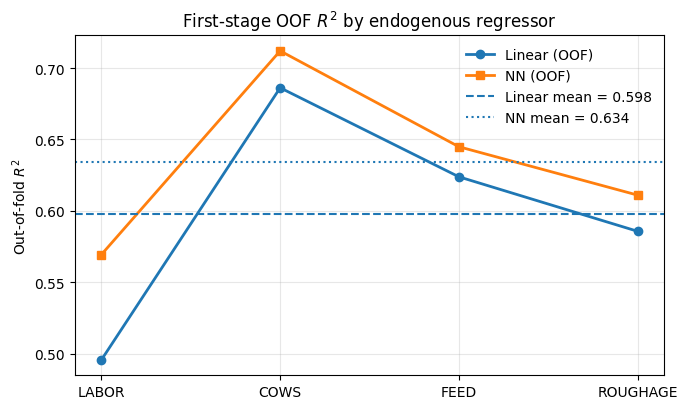

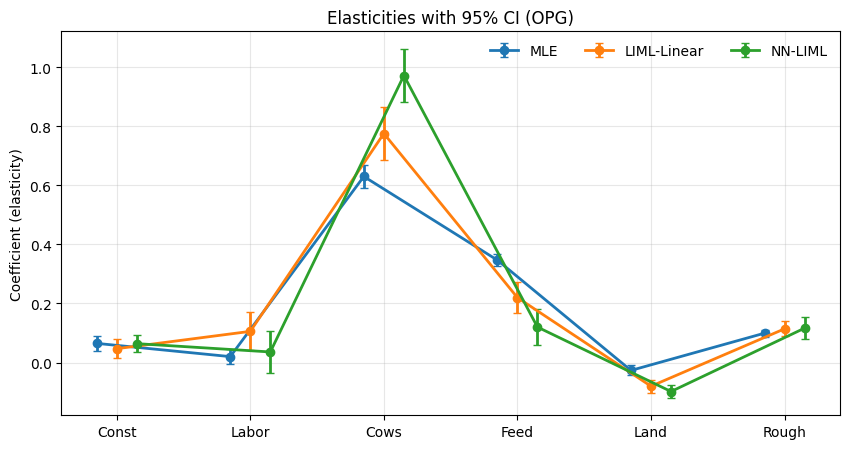


=== Est & St.Err — MLE vs LIML-Linear vs NN-LIML (no CI) ===
           MLE          LIML-Linear        NN-LIML       
           Est   St.Err     Est     St.Err   Est   St.Err
Const     0.0648 0.0136    0.0468   0.0166  0.0639 0.0152
Labor     0.0200 0.0126    0.1055   0.0329  0.0357 0.0367
Cows      0.6302 0.0194    0.7758   0.0463  0.9723 0.0462
Feed      0.3467 0.0104    0.2198   0.0266  0.1200 0.0315
Land     -0.0269 0.0086   -0.0804   0.0112 -0.0983 0.0109
Rough     0.0994 0.0058    0.1141   0.0131  0.1164 0.0194
Sigma     0.0841    NaN    0.0786      NaN  0.0744    NaN
Lambda    1.8344    NaN    1.9314      NaN  2.1238    NaN
Sigma2_u  0.0238    NaN    0.0231      NaN  0.0249    NaN
Sigma2_v  0.0071    NaN    0.0100      NaN  0.0117    NaN
TE_mean   0.8883    NaN    0.8900      NaN  0.8860    NaN

--- Diagnostics ---
R2_linear_OOF: [np.float64(0.4956351216561349), np.float64(0.6861877976098207), np.float64(0.6238286419547868), np.float64(0.5856718793164883)]
R2_nn_OOF: [np.floa

In [13]:
# ============================================================
# realdata_compare_mle_liml_nnliml_parity_with_plots.py
# Parity-fair real-data comparison: MLE vs LIML-Linear vs NN-LIML
# - Endogenous: LABOR, COWS, FEED, ROUGHAGE
# - Structural X: CONST + log(LABOR,COWS,FEED,LAND,ROUGHAGE) + YEAR dummies
# - Instruments Z (rich): CONST, LAND, PMILK, PFEED, LANDOWN, COOP dummies, YEAR dummies,
#                         optional COUNTY/ZONE dummies, + squares + selected interactions
# - First stage (both OOF):
#     * Linear: OLS with rich Z, K-fold OOF predictions
#     * NN: MLP with K-fold crossfit (OOF), optional symmetric Σ_{ηη} shrink
# - LIML stage: L1-only (given Σ̂_{ηη}), with bounds/penalties, SPD patches
# - Outputs:
#     * First-stage OOF R² table + professional line plot
#     * Σ̂_{ηη} spectrum (eigenvalues + condition #) for Linear & NN
#     * ONE wide Est/StdErr table across MLE / LIML / NN-LIML (+ Sigma/Lambda/σ² + TE_mean)
#     * Elasticities line plot (with 95% CI error bars)
# ============================================================

import os, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, Optional

from scipy.stats import norm
from scipy.optimize import minimize
from scipy.linalg import cho_factor, cho_solve

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.linear_model import LinearRegression

# ---------------- User toggles ----------------
BASE_SEED = 12345
K_FOLDS = 10
NN_EPOCHS = 200
NN_KFOLDS = 10
USE_SYMMETRIC_SHRINK = False    # If True, apply same shrinkage to BOTH Linear & NN Σ_{ηη}
RHO_SHRINK = 0.15               # shrinkage level if USE_SYMMETRIC_SHRINK=True

HIDE_YEAR_ROWS = True           # keep YEAR in X & Z, but HIDE YEAR rows in printed table
PRINT_CI = False                # do NOT print CI columns in the output table

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

np.random.seed(BASE_SEED)
torch.manual_seed(BASE_SEED)
pd.set_option('display.float_format', '{:.4f}'.format)

# ============================================================
# Utilities (+ SPD helpers)
# ============================================================
def make_spd_from_symmetric(A: np.ndarray, jitter: float = 1e-8) -> np.ndarray:
    A = 0.5*(A + A.T)
    try:
        cho_factor(A, lower=False, check_finite=False)
        return A
    except Exception:
        diag = np.diag(A) if A.size else np.array([])
        bump = max(jitter, 1e-6*(1.0 + float(np.max(np.abs(diag))) if diag.size else 1.0))
        while True:
            A_try = A + bump*np.eye(A.shape[0])
            try:
                cho_factor(A_try, lower=False, check_finite=False)
                return A_try
            except Exception:
                bump *= 10.0

def standardize_fit(X: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True)
    sd = np.where(sd < 1e-8, 1.0, sd)
    return (X - mu)/sd, mu, sd

def standardize_apply(X: np.ndarray, mu: np.ndarray, sd: np.ndarray) -> np.ndarray:
    return (X - mu)/sd

def r2_score(y, yhat):
    sst = np.sum((y - y.mean())**2)
    sse = np.sum((y - yhat)**2)
    return 1.0 - sse / max(sst, 1e-12)

def te_from_r_sigma(r: np.ndarray, sigma_u: float, sigma_c: float) -> np.ndarray:
    """
    Jondrow et al. conditional mean of exp(-u) given residual r for half-normal u and
    Normal composite symmetric part with st.dev sigma_c. Returns technical efficiency TE.
    """
    sigma2 = np.maximum(sigma_u**2 + sigma_c**2, 1e-15)
    mu_star = -r * (sigma_u**2) / sigma2
    sigma_star = (sigma_u * sigma_c) / np.sqrt(sigma2)
    denom = np.maximum(sigma_star, 1e-15)
    a = mu_star / denom
    log_ratio = norm.logcdf(a - sigma_star) - norm.logcdf(a)
    return np.exp(-mu_star + 0.5 * sigma_star**2 + log_ratio)

def shrink_cov(S: np.ndarray, rho: float = 0.10) -> np.ndarray:
    S = 0.5*(S + S.T)
    k = S.shape[0]
    tau = np.trace(S) / max(k, 1)
    S_shrunk = (1.0 - rho) * S + rho * (tau * np.eye(k))
    return make_spd_from_symmetric(S_shrunk, jitter=1e-8)

def _round_list(xs, nd=4):
    return [round(float(v), nd) for v in xs]

# ============================================================
# Data loading and design matrices (rich Z)
# ============================================================
DATA_PATHS = [
    "/content/SPANISH DATASET.csv",
    "/content/SPANISH DATASET.xlsx",
]
USECOLS = ['DEPREC','FARMEXP','MILK',
           'LABOR','COWS','FEED','LAND',
           'YEAR','COOP','PFEED','PMILK','LANDOWN',
           'COUNTY','ZONE']  # COUNTY/ZONE optional

def load_dataset() -> pd.DataFrame:
    path = None
    for p in DATA_PATHS:
        if os.path.exists(p):
            path = p
            break
    if path is None:
        raise FileNotFoundError("Could not find dataset. Checked: " + ", ".join(DATA_PATHS))
    df = pd.read_csv(path) if path.lower().endswith(".csv") else pd.read_excel(path)

    missing = [c for c in USECOLS if c not in df.columns]
    hard_missing = [c for c in missing if c not in ('COUNTY','ZONE')]
    if hard_missing:
        raise ValueError(f"Missing required columns: {hard_missing}")

    keep_cols = [c for c in USECOLS if c in df.columns]
    df = df[keep_cols].copy()

    # Create ROUGHAGE and drop zeros that break logs
    df = df[(df['DEPREC'] != 0) & (df['FARMEXP'] != 0)].copy()
    df.reset_index(drop=True, inplace=True)
    df['ROUGHAGE'] = df['FARMEXP'] + df['DEPREC']
    return df

def build_design_matrices(df: pd.DataFrame):
    # y = log(MILK) demeaned
    y = np.log(df['MILK'].values)
    y = y - y.mean()

    # Structural X logs (demeaned)
    X_raw = df[['LABOR','COWS','FEED','LAND','ROUGHAGE']].copy()
    X_log = np.log(X_raw.values)
    X_log = X_log - X_log.mean(axis=0, keepdims=True)

    X_df = pd.DataFrame(X_log, columns=['LABOR','COWS','FEED','LAND','ROUGHAGE'])
    X_df.insert(0, 'CONST', 1.0)

    # YEAR dummies kept in X (structural) and in Z (instruments)
    YEAR_dummy = pd.get_dummies(df['YEAR'], prefix='YEAR', drop_first=True, dtype=int)
    X_df = pd.concat([X_df, YEAR_dummy], axis=1)

    # Instruments Z (rich)
    Z_parts = [pd.DataFrame({'CONST': np.ones(len(df))}), X_df[['LAND']]]
    for col in ['PMILK','PFEED','LANDOWN']:
        if col in df.columns:
            Z_parts.append(df[[col]])
    if 'COOP' in df.columns:
        Z_parts.append(pd.get_dummies(df['COOP'], prefix='COOP', drop_first=True, dtype=int))
    Z_parts.append(YEAR_dummy)  # keep YEAR in Z
    if 'COUNTY' in df.columns:
        Z_parts.append(pd.get_dummies(df['COUNTY'], prefix='COUNTY', drop_first=True, dtype=int))
    if 'ZONE' in df.columns:
        Z_parts.append(pd.get_dummies(df['ZONE'], prefix='ZONE', drop_first=True, dtype=int))

    Z_A = pd.concat(Z_parts, axis=1)

    # Squares and interactions (continuous only)
    cont_cols = [c for c in ['LAND','PMILK','PFEED','LANDOWN'] if c in Z_A.columns]
    Z_sq = pd.DataFrame({c+'_SQ': Z_A[c]**2 for c in cont_cols}, index=Z_A.index) if cont_cols else pd.DataFrame(index=Z_A.index)

    Z_int = pd.DataFrame(index=Z_A.index)
    if all(c in Z_A.columns for c in ['LAND','PMILK']):  Z_int['LAND_PMILK']   = Z_A['LAND']*Z_A['PMILK']
    if all(c in Z_A.columns for c in ['LAND','PFEED']):  Z_int['LAND_PFEED']   = Z_A['LAND']*Z_A['PFEED']
    if all(c in Z_A.columns for c in ['PMILK','PFEED']): Z_int['PMILK_PFEED']  = Z_A['PMILK']*Z_A['PFEED']
    if all(c in Z_A.columns for c in ['LAND','LANDOWN']):Z_int['LAND_LANDOWN'] = Z_A['LAND']*Z_A['LANDOWN']

    Z_df = pd.concat([Z_A, Z_sq, Z_int], axis=1)

    # Endogenous block for first-stage: LABOR, COWS, FEED, ROUGHAGE
    X2_cols = ['LABOR','COWS','FEED','ROUGHAGE']
    X2 = X_df[X2_cols].values

    # Structural X for all models: CONST, LABOR, COWS, FEED, LAND, ROUGHAGE + YEAR dummies
    struct_cols = ['CONST','LABOR','COWS','FEED','LAND','ROUGHAGE'] + list(YEAR_dummy.columns)
    X_struct = X_df[struct_cols].values

    return y, X_struct, struct_cols, X2, Z_df.values, Z_df.columns

# ============================================================
# MLE baseline (no endogeneity correction)
# ============================================================
def lnL_MLE(theta, y, X):
    beta = theta[:-2]
    sigma_u = np.exp(theta[-2])
    sigma_v = np.exp(theta[-1])
    sigma2 = sigma_u**2 + sigma_v**2
    eps = y - X @ beta
    eps_sigma = eps / np.sqrt(sigma2)
    term1 = np.log(2.0 / np.sqrt(sigma2))
    term2 = norm.logpdf(eps_sigma)
    lam = sigma_u / max(sigma_v, 1e-12)
    term3 = norm.logcdf(-lam * eps_sigma)
    return -np.sum(term1 + term2 + term3)

def estimate_MLE(y, X):
    beta0 = np.linalg.lstsq(X, y, rcond=1e-8)[0]
    resid = y - X @ beta0
    s2 = np.var(resid)
    sigma_u0 = np.sqrt(max(s2/2, 0.05))
    sigma_v0 = np.sqrt(max(s2/2, 0.05))
    theta0 = np.concatenate([beta0, [np.log(sigma_u0)], [np.log(sigma_v0)]])
    bounds = [(None,None)]*len(beta0) + [(-5,5), (-5,5)]
    res = minimize(lnL_MLE, theta0, args=(y, X), method='L-BFGS-B', bounds=bounds,
                   options={'maxiter': 3000, 'ftol': 1e-9})
    if not res.success:
        theta0 = np.concatenate([beta0, [np.log(0.2)], [np.log(1.0)]])
        res = minimize(lnL_MLE, theta0, args=(y, X), method='L-BFGS-B', bounds=bounds)
    th = res.x
    return th[:-2], float(np.exp(th[-2])), float(np.exp(th[-1])), th

def mle_ll_obs(theta, y, X):
    beta = theta[:-2]; lsu = theta[-2]; lsv = theta[-1]
    sigma_u = np.exp(lsu); sigma_v = np.exp(lsv)
    sigma2 = sigma_u**2 + sigma_v**2
    eps = y - X @ beta
    eps_sig = eps/np.sqrt(sigma2)
    term1 = np.log(2.0/np.sqrt(sigma2))
    term2 = norm.logpdf(eps_sig)
    term3 = norm.logcdf(-(sigma_u/max(sigma_v,1e-12))*eps_sig)
    return term1 + term2 + term3

# ============================================================
# LIML L1-only (given Σ̂_{ηη})
# ============================================================
def lnL1_vec_fixed_sigee(beta, sig_ev, sigee, log_sigma_v, log_lambda_c, y, X, etas):
    S = make_spd_from_symmetric(sigee, jitter=1e-10)
    cF = cho_factor(S, lower=False, check_finite=False)
    w = cho_solve(cF, sig_ev, check_finite=False)  # Σ_{ηη}^{-1} Σ_{ηv}
    muci = etas @ w
    r = y - X @ beta - muci

    sigma_v = np.exp(log_sigma_v)
    lam_c   = np.exp(log_lambda_c)
    correction = float(sig_ev @ w)                  # Σ_{ηv}ᵀ Σ_{ηη}^{-1} Σ_{ηv}
    sigma_c2 = sigma_v**2 - correction
    if sigma_c2 <= 1e-12:
        return np.full(y.shape[0], -1e20)
    sigma_c = np.sqrt(sigma_c2)
    sigma2  = sigma_c2 + (lam_c * sigma_c)**2
    z = -(lam_c / np.sqrt(sigma2)) * r
    z = np.clip(z, -10, 10)
    lPhi = norm.logcdf(z)
    return -0.5*np.log(sigma2) - 0.5*(r**2 / sigma2) + lPhi

def neg_loglik_L1_only_with_penalty(theta, y, X, etas, sigee, k2):
    p = X.shape[1]
    beta = theta[:p]
    sig_ev = theta[p:p+k2]
    log_sigma_v = theta[-2]
    log_lambda_c = theta[-1]
    l1 = lnL1_vec_fixed_sigee(beta, sig_ev, sigee, log_sigma_v, log_lambda_c, y, X, etas)
    val = -float(np.sum(l1))
    if not np.isfinite(val):
        return 1e20
    # feasibility + mild centers
    S = make_spd_from_symmetric(sigee, jitter=1e-10)
    cF = cho_factor(S, lower=False, check_finite=False)
    w = cho_solve(cF, sig_ev, check_finite=False)
    correction = float(sig_ev @ w)
    sigma_v = np.exp(log_sigma_v)
    sigma_c2 = sigma_v**2 - correction
    if sigma_c2 <= 1e-12:
        return 1e20
    val += 0.02*(np.sum(beta**2) + np.sum(sig_ev**2))
    val += 0.05*(log_sigma_v - 0.0)**2 + 0.08*(log_lambda_c - np.log(0.3))**2
    return val

def estimate_LIML_L1_only(y, X, etas, sigee, fallback=True):
    n, p = X.shape
    k2   = etas.shape[1]
    beta0 = np.linalg.lstsq(X, y, rcond=1e-8)[0]
    e0 = y - X @ beta0
    try:
        sig_ev0 = np.linalg.lstsq(etas, e0, rcond=1e-8)[0]
    except np.linalg.LinAlgError:
        sig_ev0 = np.zeros(k2)

    starts_sigma_v = [np.log(0.6), np.log(1.0), np.log(1.5)]
    starts_lambda_c = [np.log(0.2), np.log(0.3), np.log(0.6)]
    lower = [-np.inf]*p + [-5.0]*k2 + [np.log(0.10), np.log(0.05)]
    upper = [ np.inf]*p + [ 5.0]*k2 + [np.log(5.00), np.log(3.00)]
    bounds = list(zip(lower, upper))

    best_res, best_fun = None, np.inf
    methods = ['L-BFGS-B'] + (['SLSQP'] if fallback else [])
    for sv in starts_sigma_v:
        for lc in starts_lambda_c:
            theta0 = np.concatenate([beta0, sig_ev0, [sv, lc]])
            for m in methods:
                try:
                    res = minimize(neg_loglik_L1_only_with_penalty, theta0,
                                   args=(y, X, etas, sigee, k2),
                                   method=m, bounds=bounds,
                                   options={'maxiter': 6000, 'ftol': 1e-9})
                    if res.fun < best_fun:
                        best_res, best_fun = res, res.fun
                except Exception as e:
                    warnings.warn(f"LIML optimization failed with {m}: {e}")
    if best_res is None:
        raise RuntimeError("All LIML optimization attempts failed.")

    theta = best_res.x
    beta_hat = theta[:p]
    sig_ev_hat = theta[p:p+k2]
    log_sigma_v = theta[-2]
    log_lambda_c = theta[-1]

    S = make_spd_from_symmetric(sigee, jitter=1e-10)
    cF = cho_factor(S, lower=False, check_finite=False)
    w = cho_solve(cF, sig_ev_hat, check_finite=False)
    correction = float(sig_ev_hat @ w)

    sigma_v_hat = float(np.exp(log_sigma_v))
    sigma_c2_hat = sigma_v_hat**2 - correction
    sigma_c_hat = float(np.sqrt(max(sigma_c2_hat, 1e-15)))
    lambda_c_hat = float(np.exp(log_lambda_c))
    sigma_u_hat = float(lambda_c_hat * sigma_c_hat)
    return {
        'success': best_res.success,
        'message': best_res.message,
        'beta': beta_hat, 'sig_ev': sig_ev_hat,
        'sigma_v': sigma_v_hat, 'sigma_c': sigma_c_hat,
        'sigma_u': sigma_u_hat, 'lambda_c': lambda_c_hat, 'w': w,
        'theta': theta, 'correction': correction
    }

# ============================================================
# OOF Linear first-stage + NN first-stage (crossfit)
# ============================================================
def kfold_indices(n: int, K: int, seed: int = BASE_SEED):
    rng = np.random.default_rng(seed)
    idx = np.arange(n); rng.shuffle(idx)
    folds = np.array_split(idx, K)
    for k in range(K):
        te = folds[k]
        tr = np.hstack([folds[j] for j in range(K) if j != k])
        yield tr, te

def first_stage_linear_oof(Z: np.ndarray, X2: np.ndarray, K: int = 10, seed: int = BASE_SEED):
    n, k2 = X2.shape
    X2_hat = np.zeros_like(X2)
    for tr, te in kfold_indices(n, K, seed):
        for j in range(k2):
            m = LinearRegression().fit(Z[tr], X2[tr, j])
            X2_hat[te, j] = m.predict(Z[te])
    r2 = [r2_score(X2[:, j], X2_hat[:, j]) for j in range(k2)]
    return X2_hat, r2

@dataclass
class NNConfig:
    epochs: int = NN_EPOCHS
    batch_size: int = 32
    lr: float = 2e-4
    weight_decay: float = 1e-3
    hidden: Tuple[int, ...] = (128, 64)
    dropout: float = 0.45
    device: str = DEVICE
    seed: int = BASE_SEED
    K: int = NN_KFOLDS

class RF_NN(nn.Module):
    def __init__(self, z_dim: int, k2: int, hidden=(128, 64), dropout=0.45):
        super().__init__()
        layers = []
        prev = z_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), nn.ELU(), nn.Dropout(dropout)]
            prev = h
        layers += [nn.Linear(prev, k2)]
        self.mlp = nn.Sequential(*layers)
        self.Lpar = nn.Parameter(torch.eye(k2) * 0.5)

    def _Sigma(self):
        L = torch.tril(self.Lpar)
        d = F.softplus(torch.diag(L)) + 0.5
        L = L - torch.diag(torch.diag(L)) + torch.diag(d)
        return L @ L.T, L

    def nll(self, Zb, X2b):
        X2_hat = self.mlp(Zb)
        resid = X2b - X2_hat
        Sigma, L = self._Sigma()
        Y = torch.linalg.solve_triangular(L, resid.T, upper=False)
        quad = (Y**2).sum()
        logdet = 2.0 * torch.log(torch.clamp(torch.diag(L), min=1e-6)).sum()
        m = resid.shape[0]
        reg = 1e-3 * torch.norm(self.Lpar)**2
        return 0.5 * (quad + m*logdet) + reg

def crossfit_nn_l2(Z: np.ndarray, X2: np.ndarray, cfg: NNConfig):
    n, _ = Z.shape
    k2 = X2.shape[1]
    eta_hat = np.zeros((n, k2), dtype=np.float64)

    for tr, te in kfold_indices(n, cfg.K, seed=cfg.seed):
        Ztr, Zte = Z[tr], Z[te]
        X2tr, X2te = X2[tr], X2[te]

        Ztr_std, Zmu, Zsd = standardize_fit(Ztr)
        Zte_std = standardize_apply(Zte, Zmu, Zsd)
        X2tr_std, X2mu, X2sd = standardize_fit(X2tr)
        X2te_std = standardize_apply(X2te, X2mu, X2sd)

        # small in-train validation
        ntr = Ztr_std.shape[0]
        nva = max(6, int(0.10 * ntr))
        va_idx = np.arange(ntr)[:nva]
        tr_idx = np.arange(ntr)[nva:]

        device = torch.device(cfg.device)
        model = RF_NN(Ztr_std.shape[1], k2, cfg.hidden, cfg.dropout).to(device)
        opt = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

        def lr_lambda(epoch):
            if epoch < 40:
                return 0.1 + 0.9 * (epoch/40)
            return 0.5 * (1 + math.cos(math.pi * (epoch-40)/max(cfg.epochs-40,1)))
        scheduler = optim.lr_scheduler.LambdaLR(opt, lr_lambda)

        Ztr_t = torch.tensor(Ztr_std[tr_idx], dtype=torch.float32, device=device)
        X2tr_t= torch.tensor(X2tr_std[tr_idx],dtype=torch.float32, device=device)
        Zva_t = torch.tensor(Ztr_std[va_idx], dtype=torch.float32, device=device)
        X2va_t= torch.tensor(X2tr_std[va_idx],dtype=torch.float32, device=device)

        best, best_state, patience, wait = np.inf, None, 20, 0
        steps = max(1, Ztr_t.shape[0] // cfg.batch_size)
        for epoch in range(cfg.epochs):
            model.train()
            perm = torch.randperm(Ztr_t.shape[0], device=device)
            for s in range(steps):
                si = s * cfg.batch_size
                ei = min((s+1)*cfg.batch_size, Ztr_t.shape[0])
                if si >= ei: break
                idx = perm[si:ei]
                loss = model.nll(Ztr_t[idx], X2tr_t[idx])
                opt.zero_grad(); loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                opt.step()
            # early stopping check every 5 epochs
            if epoch % 5 == 0:
                model.eval()
                with torch.no_grad():
                    val_loss = model.nll(Zva_t, X2va_t).item()
                if val_loss < best - 1e-6:
                    best = val_loss
                    best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
                    wait = 0
                else:
                    wait += 1
                if wait >= patience: break
            scheduler.step()
        if best_state is not None:
            model.load_state_dict(best_state)
        model.eval()
        with torch.no_grad():
            Zte_t = torch.tensor(Zte_std, dtype=torch.float32, device=device)
            X2_hat_te_std = model.mlp(Zte_t).cpu().numpy()
        X2_hat_te = X2_hat_te_std * X2sd + X2mu
        eta_hat[te] = X2te - X2_hat_te

    S = np.cov(eta_hat, rowvar=False)
    S = make_spd_from_symmetric(S, jitter=1e-8)
    return eta_hat, S

# ============================================================
# OPG VCOV (for β only display)
# ============================================================
def pack_theta_liml(beta, sig_ev, log_sigma_v, log_lambda_c):
    return np.concatenate([beta, sig_ev, [log_sigma_v, log_lambda_c]])

def ll_obs_liml(theta, y, X, etas, sigee):
    p, k2 = X.shape[1], etas.shape[1]
    beta = theta[:p]
    sig_ev = theta[p:p+k2]
    lsv = theta[-2]; llc = theta[-1]
    return lnL1_vec_fixed_sigee(beta, sig_ev, sigee, lsv, llc, y, X, etas)

def opg_vcov(theta_hat, ll_obs_fun, eps=1e-6):
    base = ll_obs_fun(theta_hat)
    n = base.shape[0]
    k = theta_hat.size
    G = np.empty((n, k))
    for j in range(k):
        th = theta_hat.copy(); th[j] += eps
        fwd = ll_obs_fun(th)
        G[:, j] = (fwd - base) / eps
    OPG = G.T @ G
    try:
        vcov = np.linalg.inv(OPG)
    except np.linalg.LinAlgError:
        vcov = np.linalg.pinv(OPG)
    return vcov

def ci95(est: np.ndarray, se: np.ndarray):
    z = 1.959963984540054
    lo = est - z*se
    hi = est + z*se
    return lo, hi

# ============================================================
# Plot helpers (matplotlib)
# ============================================================
def plot_first_stage_r2(r2_lin, r2_nn, names=('LABOR','COWS','FEED','ROUGHAGE')):
    x = np.arange(len(names))
    plt.figure(figsize=(7,4.2))
    plt.plot(x, r2_lin, marker='o', linewidth=2, label='Linear (OOF)')
    plt.plot(x, r2_nn,  marker='s', linewidth=2, label='NN (OOF)')
    m_lin = float(np.mean(r2_lin)); m_nn = float(np.mean(r2_nn))
    plt.axhline(m_lin, linestyle='--', linewidth=1.5, label=f'Linear mean = {m_lin:.3f}')
    plt.axhline(m_nn,  linestyle=':',  linewidth=1.5, label=f'NN mean = {m_nn:.3f}')
    plt.xticks(x, names)
    plt.ylabel('Out-of-fold $R^2$')
    plt.title('First-stage OOF $R^2$ by endogenous regressor')
    plt.grid(alpha=0.3)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

def plot_elasticities_with_ci(core_names, betas, ses, model_names=('MLE','LIML-Linear','NN-LIML')):
    disp = ['Const','Labor','Cows','Feed','Land','Rough']
    idxs = list(range(len(core_names)))
    plt.figure(figsize=(8.6,4.6))
    for m, mlabel in zip(['MLE','LIML-Linear','NN-LIML'], model_names):
        est = np.array([betas[m][i] for i in idxs])
        se  = np.array([ses[m][i]   for i in idxs])
        # CI only for the plot (requested table has no CI)
        offset = {'MLE':-0.15,'LIML-Linear':0.0,'NN-LIML':0.15}[m]
        x = np.arange(len(disp)) + offset
        plt.errorbar(x, est, yerr=1.96*se, fmt='-o', capsize=3, linewidth=2, label=mlabel)
    plt.xticks(np.arange(len(disp)), disp)
    plt.ylabel('Coefficient (elasticity)')
    plt.title('Elasticities with 95% CI (OPG)')
    plt.grid(alpha=0.3)
    plt.legend(frameon=False, ncol=3)
    plt.tight_layout()
    plt.show()

# ============================================================
# Comparison runner
# ============================================================
def compare_all_realdata(nn_cfg: Optional[NNConfig] = None, seed: int = BASE_SEED):
    if nn_cfg is None: nn_cfg = NNConfig()
    np.random.seed(seed); torch.manual_seed(seed)

    df = load_dataset()
    y, X, Xcols, X2, Z, Zcols = build_design_matrices(df)
    n, k2 = X2.shape

    print("\n=== Real-data comparison (parity-fair OOF): MLE vs LIML-Linear vs NN-LIML ===")
    print(f"Settings: K_FOLDS={K_FOLDS}, NN_KFOLDS={nn_cfg.K}, SYMM_SHRINK={USE_SYMMETRIC_SHRINK}, RHO={RHO_SHRINK}")

    # Z columns list
    print("\nZ columns used (for OLS/Lasso):")
    print(list(Zcols))

    # ---------- First-stage: Linear (OOF) ----------
    X2hat_lin, r2_lin = first_stage_linear_oof(Z, X2, K=K_FOLDS, seed=seed)
    eta_lin = X2 - X2hat_lin
    S_lin = make_spd_from_symmetric(np.cov(eta_lin, rowvar=False), jitter=1e-8)

    # ---------- First-stage: NN (OOF) ----------
    eta_nn, S_nn = crossfit_nn_l2(Z, X2, nn_cfg)
    X2hat_nn = X2 - eta_nn
    r2_nn = [r2_score(X2[:, j], X2hat_nn[:, j]) for j in range(k2)]

    # ---------- Optional symmetric shrinkage ----------
    if USE_SYMMETRIC_SHRINK:
        S_lin = shrink_cov(S_lin, rho=RHO_SHRINK)
        S_nn  = shrink_cov(S_nn,  rho=RHO_SHRINK)

    # ---------- Report OOF R² ----------
    names = ['LABOR','COWS','FEED','ROUGHAGE']
    print("\n--- First-stage OOF R^2 (order: LABOR, COWS, FEED, ROUGHAGE) ---")
    print(f"Linear: {_round_list(r2_lin)}  | mean = {round(float(np.mean(r2_lin)),4)}")
    print(f"NN    : {_round_list(r2_nn)}  | mean = {round(float(np.mean(r2_nn)),4)}")

    # ---------- Σ̂_{ηη} spectra ----------
    evals_lin = np.linalg.eigvalsh(S_lin); cond_lin = float(evals_lin.max()/max(evals_lin.min(),1e-12))
    evals_nn  = np.linalg.eigvalsh(S_nn);  cond_nn  = float(evals_nn.max()/max(evals_nn.min(),1e-12))
    print("\n== Σ̂_{ηη} spectrum ==")
    print("Linear eigvals:", np.round(evals_lin, 6).tolist(), "| cond =", round(cond_lin, 2))
    print("NN     eigvals:", np.round(evals_nn,  6).tolist(), "| cond =", round(cond_nn, 2))

    # ---------- MLE baseline ----------
    beta_mle, su_mle, sv_mle, th_mle = estimate_MLE(y, X)
    r_mle = y - X @ beta_mle
    te_mle = te_from_r_sigma(r_mle, su_mle, sv_mle)               # for TE_mean in table
    te_mean_mle = float(np.mean(te_mle))

    # OPG SE for β (MLE)
    def mle_ll(theta): return mle_ll_obs(theta, y, X)
    vcov_mle = opg_vcov(th_mle, mle_ll, eps=1e-6)
    p = X.shape[1]
    se_beta_mle = np.sqrt(np.clip(np.diag(vcov_mle)[:p], 0, np.inf))

    # ---------- LIML two-stage: Linear ----------
    liml_lin = estimate_LIML_L1_only(y, X, eta_lin, S_lin, fallback=True)
    r_lin = y - X @ liml_lin['beta'] - eta_lin @ liml_lin['w']
    te_lin = te_from_r_sigma(r_lin, liml_lin['sigma_u'], liml_lin['sigma_c'])
    te_mean_lin = float(np.mean(te_lin))
    th_lin = pack_theta_liml(liml_lin['beta'], liml_lin['sig_ev'],
                             np.log(liml_lin['sigma_v']), np.log(liml_lin['lambda_c']))
    def lin_ll(th): return ll_obs_liml(th, y, X, eta_lin, S_lin)
    vcov_lin = opg_vcov(th_lin, lin_ll, eps=1e-6)
    se_beta_lin = np.sqrt(np.clip(np.diag(vcov_lin)[:p], 0, np.inf))

    # ---------- LIML two-stage: NN ----------
    liml_nn  = estimate_LIML_L1_only(y, X, eta_nn, S_nn, fallback=True)
    r_nn = y - X @ liml_nn['beta'] - eta_nn @ liml_nn['w']
    te_nn = te_from_r_sigma(r_nn, liml_nn['sigma_u'], liml_nn['sigma_c'])
    te_mean_nn = float(np.mean(te_nn))
    th_nn = pack_theta_liml(liml_nn['beta'], liml_nn['sig_ev'],
                            np.log(liml_nn['sigma_v']), np.log(liml_nn['lambda_c']))
    def nn_ll(th): return ll_obs_liml(th, y, X, eta_nn, S_nn)
    vcov_nn = opg_vcov(th_nn, nn_ll, eps=1e-6)
    se_beta_nn = np.sqrt(np.clip(np.diag(vcov_nn)[:p], 0, np.inf))

    # ---------- YEAR rows control (hidden in output if requested) ----------
    core_disp = ["Const","Labor","Cows","Feed","Land","Rough"]
    core_cols = ['CONST','LABOR','COWS','FEED','LAND','ROUGHAGE']
    all_years = sorted([c for c in Xcols if c.startswith("YEAR_")])
    d_labels = [] if HIDE_YEAR_ROWS else all_years
    all_beta_rows_disp = core_disp + ([*d_labels] if d_labels else [])

    # ---- optional YEAR table (only when showing) ----
    year_tbl = None
    if (not HIDE_YEAR_ROWS) and all_years:
        y_idx = [Xcols.index(c) for c in all_years]
        def as_series(beta):
            return pd.Series({c: beta[i] for c,i in zip(all_years, y_idx)})
        year_tbl = pd.concat([
            as_series(beta_mle).rename("MLE"),
            as_series(liml_lin['beta']).rename("LIML-Linear"),
            as_series(liml_nn['beta']).rename("NN-LIML"),
        ], axis=1).round(4)

    # -------- Unified Est/StdErr table builder --------
    def est_se_df(beta, se, include_ci: bool):
        est = pd.Series(beta, index=Xcols).rename("Est")
        se_ = pd.Series(se,   index=Xcols).rename("St.Err")
        cols = [est, se_]
        df = pd.concat(cols, axis=1)
        keep = core_cols + d_labels
        df = df.loc[keep].copy()
        disp_index = [dict(zip(core_cols, core_disp)).get(i, i) for i in df.index]
        df.index = disp_index
        df = df.loc[all_beta_rows_disp] if all_beta_rows_disp else df
        return df

    mle_es  = est_se_df(beta_mle,              se_beta_mle, include_ci=PRINT_CI)
    lin_es  = est_se_df(liml_lin['beta'],      se_beta_lin, include_ci=PRINT_CI)
    nn_es   = est_se_df(liml_nn['beta'],       se_beta_nn,  include_ci=PRINT_CI)

    # Tail (Sigma/Lambda/σ² + TE_mean) — estimates only (SE n/a here)
    def tail_block(model_key: str) -> pd.DataFrame:
        if model_key == "MLE":
            sigma_c = float(sv_mle); lam = float(su_mle / max(sv_mle, 1e-15))
            s2u, s2v = float(su_mle**2), float(sv_mle**2)
            te_m = te_mean_mle
        elif model_key == "LIML":
            d = liml_lin; sigma_c = float(d["sigma_c"]); lam=float(d["lambda_c"])
            s2u=float(d["sigma_u"]**2); s2v=float(d["sigma_v"]**2); te_m = te_mean_lin
        else:
            d = liml_nn;  sigma_c = float(d["sigma_c"]); lam=float(d["lambda_c"])
            s2u=float(d["sigma_u"]**2); s2v=float(d["sigma_v"]**2); te_m = te_mean_nn
        tail = pd.DataFrame(
            {"Est":[sigma_c, lam, s2u, s2v, te_m],
             "St.Err":[np.nan,np.nan,np.nan,np.nan,np.nan]},
            index=["Sigma","Lambda","Sigma2_u","Sigma2_v","TE_mean"]
        )
        return tail

    mle_full = pd.concat([mle_es, tail_block("MLE")], axis=0)
    lin_full = pd.concat([lin_es, tail_block("LIML")], axis=0)
    nn_full  = pd.concat([nn_es,  tail_block("NN")],   axis=0)

    wide = pd.concat([mle_full, lin_full, nn_full], axis=1,
                     keys=["MLE","LIML-Linear","NN-LIML"]).astype(float).round(4)

    # ------------- Return pack -------------
    diags = {
        'R2_linear_OOF': r2_lin,
        'R2_nn_OOF': r2_nn,
        'Sigma_eta_eta_eigs_Linear': np.round(evals_lin, 6).tolist(),
        'Sigma_eta_eta_cond_Linear': cond_lin,
        'Sigma_eta_eta_eigs_NN': np.round(evals_nn, 6).tolist(),
        'Sigma_eta_eta_cond_NN': cond_nn,
        'LIML_linear_success': liml_lin['success'],
        'LIML_linear_message': liml_lin['message'],
        'LIML_nn_success': liml_nn['success'],
        'LIML_nn_message': liml_nn['message'],
        'epochs': nn_cfg.epochs, 'Kfold_linear': K_FOLDS, 'Kfold_nn': nn_cfg.K,
        'symmetric_shrink': USE_SYMMETRIC_SHRINK, 'rho_shrink': RHO_SHRINK
    }

    # --------- Plots ---------
    plot_first_stage_r2(r2_lin, r2_nn, names=names)
    # Prepare elasticities arrays for the 6 core regressors (Xcols order)
    core_cols_only = ['CONST','LABOR','COWS','FEED','LAND','ROUGHAGE']
    core_idx = [Xcols.index(c) for c in core_cols_only]
    betas = {
        'MLE':         np.array(beta_mle)[core_idx],
        'LIML-Linear': np.array(liml_lin['beta'])[core_idx],
        'NN-LIML':     np.array(liml_nn['beta'])[core_idx],
    }
    ses = {
        'MLE':         np.array(se_beta_mle)[core_idx],
        'LIML-Linear': np.array(se_beta_lin)[core_idx],
        'NN-LIML':     np.array(se_beta_nn)[core_idx],
    }
    plot_elasticities_with_ci(core_cols_only, betas, ses)

    return year_tbl, wide, diags

# ---------------- Main --------------------------
if __name__ == "__main__":
    cfg = NNConfig(epochs=NN_EPOCHS, K=NN_KFOLDS)
    year_tbl, wide, diags = compare_all_realdata(cfg, seed=BASE_SEED)

    # Unified Est/SE table (no CI; YEAR rows hidden if HIDE_YEAR_ROWS=True)
    print("\n=== Est & St.Err — MLE vs LIML-Linear vs NN-LIML (no CI) ===")
    pd.set_option("display.width", 220)
    pd.set_option("display.max_columns", 120)
    pd.set_option("display.colheader_justify", "center")
    print(wide)

    if (not HIDE_YEAR_ROWS) and (year_tbl is not None):
        print("\n--- YEAR coefficients (shown because HIDE_YEAR_ROWS=False) ---")
        print(year_tbl)

    print("\n--- Diagnostics ---")
    for k, v in diags.items():
        print(f"{k}: {v}")
